In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from resnet_models import create_resnet50_model

2023-01-26 13:36:43.979394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 13:36:44.225202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-26 13:36:44.225223: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-26 13:36:45.642174: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Loading Data Set
Three sets are created: training, validation, and test. 
- Labels are generated based on the folder structure. Class name must correspond to the subfolder name.
- Loading in batches, of size 32, to reduce memory usage.
- Label mode is set to categorical, which means that the labels are encoded as a categorical vector.

Bilinear interploation is set to default. This specify the method used in the resizing procedure. By default aspect ratio is not perserved, i.e., the ratio between image width and height.

One hot encoding is utilized when label mode is set to categorical.


The image load documentation is available [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) and an example is available [here](https://keras.io/api/data_loading/image/).

In [2]:
path = "../../baseline_training_set/"
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=path,
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=32,
    validation_split=0.1,
    subset='both',
    image_size=(224, 224)
    )
# check if the sets have the same number of classes
assert len(train_ds.class_names) == len(validation_ds.class_names)

Found 1782281 files belonging to 15 classes.
Using 1604053 files for training.
Using 178228 files for validation.


2023-01-26 13:37:47.680832: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-26 13:37:47.681017: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-26 13:37:47.681044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (brothel420): /proc/driver/nvidia/version does not exist
2023-01-26 13:37:47.682099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Visualizing the Data

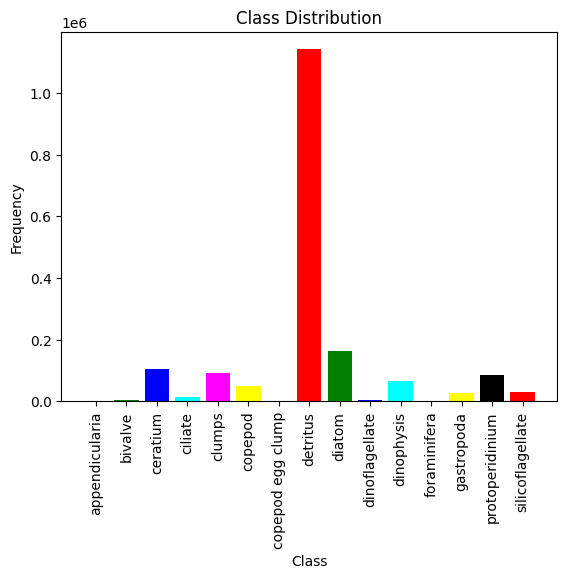

In [3]:
# histogram of class distribution in the data set
# remove underscores from class names
class_dist = {class_name.replace('_', ' ') : 0 for class_name in train_ds.class_names}
for label in os.listdir(path):
    class_dist[label.replace('_', ' ')] = len(os.listdir(path + label))

# plot the histogram
plt.bar(class_dist.keys(), class_dist.values(), color=['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [4]:
for label, count in zip(class_dist.keys(), class_dist.values()):
    print(f'{label}: {count/sum(class_dist.values())*100:.2f}%')

appendicularia: 0.02%
bivalve: 0.25%
ceratium: 5.80%
ciliate: 0.75%
clumps: 5.08%
copepod: 2.70%
copepod egg clump: 0.15%
detritus: 64.02%
diatom: 9.15%
dinoflagellate: 0.25%
dinophysis: 3.78%
foraminifera: 0.01%
gastropoda: 1.56%
protoperidinium: 4.79%
silicoflagellate: 1.69%


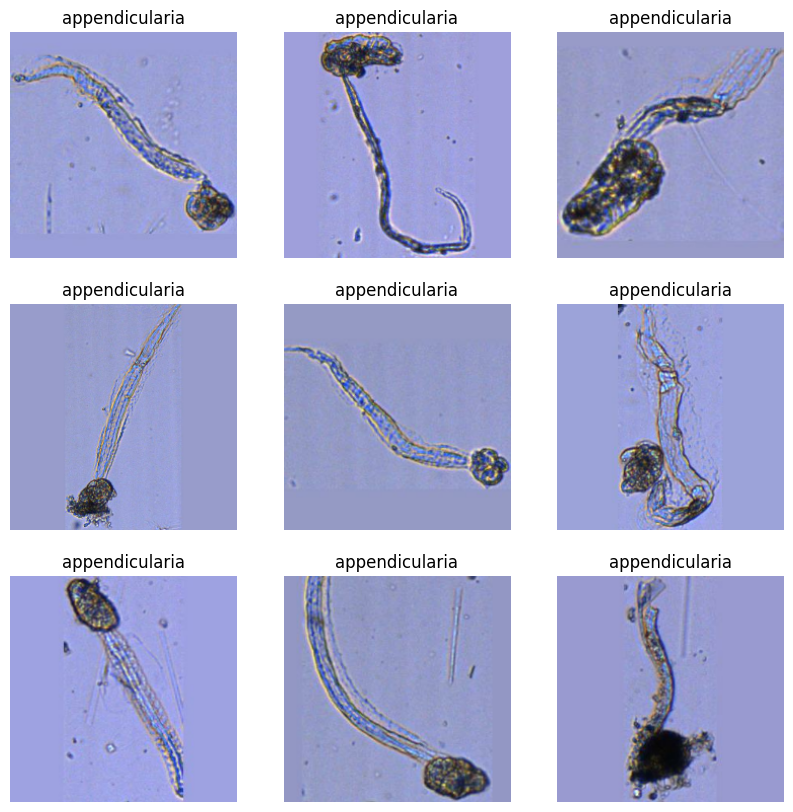

In [5]:
# plot some images from the data set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[np.argmax(labels[i])])
        plt.axis("off")

# Model Creation

In [6]:
def layer_state(model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name, "-" ,layer.trainable)

In [7]:
model = create_resnet50_model(len(train_ds.class_names))
# print the layer state
layer_state(model)

0 resnet50 - False
1 flatten - True
2 batch_normalization - True
3 dense - True
4 dropout - True
5 batch_normalization_1 - True
6 dense_1 - True
7 dropout_1 - True
8 batch_normalization_2 - True
9 dense_2 - True
10 dropout_2 - True
11 batch_normalization_3 - True
12 dense_3 - True


2023-01-26 13:37:52.450764: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.
2023-01-26 13:37:52.488220: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.
2023-01-26 13:37:52.505274: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.


In [8]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"]) # compile the model


In [9]:
# define variables for training
epochs = 10
batch_size = 32
verbose = 1

In [10]:
model.fit(train_ds, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=validation_ds) # train the model

Epoch 1/10


2023-01-26 13:37:54.138259: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.
2023-01-26 13:37:54.146702: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.


   18/50127 [..............................] - ETA: 26:24:55 - loss: 3.3114 - accuracy: 0.0764

KeyboardInterrupt: 